In [1]:
import os
import json
import warnings
import random
import copy

import dgl
import torch
import torch_geometric as tg

import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import dgl.nn.pytorch as dglnn

from graphlime import GraphLIME
from mumin import MuminDataset

import torchmetrics as tm

from tqdm.notebook import tqdm
from collections import defaultdict

from torch_geometric.data import Data as tgData

from transformers import AutoModel, AutoTokenizer, AutoModelForSequenceClassification

from mumin_explainable.architectures.graphs import GAT
from mumin_explainable.processor.tweetnormalizer import normalizeTweet

from dotenv import load_dotenv

import mlflow


%matplotlib inline

warnings.filterwarnings('ignore')
_= torch.manual_seed(42)

# Setup mumin graph

In [2]:
size= 'small'
dataset_mumin = MuminDataset(
    twitter_bearer_token=os.getenv('TWITTER_BEARER_TOKEN'),
    size=size,
    dataset_path=f'./data/datasets/mumin-{size}.zip'
)
dataset_mumin.compile()
mumin_graph = dataset_mumin.to_dgl()
mumin_graph

2023-08-24 13:35:31,688 [INFO] Loading dataset
2023-08-24 13:36:09,758 [INFO] Outputting to DGL


Graph(num_nodes={'article': 1446, 'claim': 2083, 'hashtag': 27802, 'image': 1015, 'reply': 177816, 'tweet': 4061, 'user': 152038},
      num_edges={('article', 'has_article_inv', 'tweet'): 1890, ('claim', 'discusses_inv', 'tweet'): 4749, ('hashtag', 'has_hashtag_inv', 'tweet'): 2284, ('hashtag', 'has_hashtag_inv', 'user'): 49626, ('image', 'has_image_inv', 'tweet'): 1019, ('reply', 'posted_inv', 'user'): 177816, ('reply', 'quote_of', 'tweet'): 88495, ('reply', 'reply_to', 'tweet'): 78576, ('tweet', 'discusses', 'claim'): 4749, ('tweet', 'has_article', 'article'): 1890, ('tweet', 'has_hashtag', 'hashtag'): 2284, ('tweet', 'has_image', 'image'): 1019, ('tweet', 'mentions', 'user'): 1112, ('tweet', 'posted_inv', 'user'): 4061, ('tweet', 'quote_of_inv', 'reply'): 88495, ('tweet', 'reply_to_inv', 'reply'): 78576, ('tweet', 'retweeted_inv', 'user'): 12800, ('user', 'follows', 'user'): 17974, ('user', 'follows_inv', 'user'): 17974, ('user', 'has_hashtag', 'hashtag'): 49626, ('user', 'mentions

# Setup subgraph

In [3]:
user_df = dataset_mumin.nodes['user']
tweet_df = dataset_mumin.nodes['tweet']

user_posted_tweet_df = dataset_mumin.rels[('user', 'posted', 'tweet')]
user_posted_tweet_subgraph = dgl.edge_type_subgraph(mumin_graph, etypes=[('user', 'posted', 'tweet')])

## Filter language

In [4]:
LANG = 'multilingual'
tweet_ds_copy = dataset_mumin.nodes['tweet'].dropna()
lang_tweets = (tweet_ds_copy['lang'] == LANG).to_list()
del(tweet_ds_copy)

if LANG == 'multilingual':
    lang_tweets = [True] * len(lang_tweets)
tweet_train_mask = user_posted_tweet_subgraph.nodes['tweet'].data['train_mask'] & torch.tensor(lang_tweets)
tweet_val_mask = user_posted_tweet_subgraph.nodes['tweet'].data['val_mask'] & torch.tensor(lang_tweets)
tweet_test_mask = user_posted_tweet_subgraph.nodes['tweet'].data['test_mask'] & torch.tensor(lang_tweets)

# Setup dataset

In [5]:
edges_index = torch.cat([
    user_posted_tweet_subgraph.edges(etype='posted')[0].unsqueeze(0),
    user_posted_tweet_subgraph.edges(etype='posted')[1].unsqueeze(0)
], dim=0)
data = tgData(
    x=user_posted_tweet_subgraph.nodes['tweet'].data['feat'],
    y=user_posted_tweet_subgraph.nodes['tweet'].data['label'],
    train_mask=tweet_train_mask,
    val_mask=tweet_val_mask,
    test_mask=tweet_test_mask,
    edge_index=edges_index.long())

# Enhance with text-based features

In [6]:
from transformers import AutoModelForSequenceClassification

TEXT_DIM = 100

LANG_TOOL_MAP = {
    'multilingual': {
        'bertweet': AutoModel.from_pretrained('vinai/bertweet-base'),
        'tokenizer': AutoTokenizer.from_pretrained('vinai/bertweet-base', use_fast=False)
    },
    'en': {
        'bertweet': AutoModel.from_pretrained('vinai/bertweet-base'),
        'tokenizer': AutoTokenizer.from_pretrained('vinai/bertweet-base', use_fast=False)
    },
    'pt': {
        'bertweet': AutoModel.from_pretrained('melll-uff/bertweetbr'),
        'tokenizer': AutoTokenizer.from_pretrained('melll-uff/bertweetbr', normalization=True)
    },
    'es': {
        'bertweet': AutoModel.from_pretrained('pysentimiento/robertuito-base-cased'),
        'tokenizer': AutoTokenizer.from_pretrained('pysentimiento/robertuito-base-cased')
    }
}

bertweet = LANG_TOOL_MAP[LANG]['bertweet']
tokenizer = LANG_TOOL_MAP[LANG]['tokenizer']

def tweetencoder(x, text_dim):
    try:
        x = bertweet(torch.tensor([tokenizer.encode(normalizeTweet(x))])).pooler_output
    except:
        x = bertweet(torch.tensor([tokenizer.encode('')])).pooler_output
    return nn.Linear(768, text_dim)(x).tolist()[0]

In [7]:
tweet_df['text_encoding'] = str([0] * TEXT_DIM)
if LANG == 'multilingual':
    tweet_df['text_encoding'] = [tweetencoder(text, TEXT_DIM) for text in tweet_df['text']]
else:
    tweet_df['text_encoding'] = [tweetencoder(text, TEXT_DIM) if lang == LANG else str([0] * TEXT_DIM) for text,lang in zip(tweet_df['text'], tweet_df['lang'])]

In [8]:
new_embedding_columns = [f'emb{i}' for i in range(TEXT_DIM)]

tweet_embeddings_split_df = pd.DataFrame(
    [x if not isinstance(x, str) else eval(x) for x in tweet_df['text_encoding'].tolist()],
    index=tweet_df.index,
    columns=new_embedding_columns
)
tweet_df = pd.concat([tweet_df, tweet_embeddings_split_df], axis=1)
tweet_df.dropna(inplace=True)
display(tweet_df)

,tweet_id,text,created_at,lang,source,num_retweets,num_replies,num_quote_tweets,text_emb,lang_emb,...,emb90,emb91,emb92,emb93,emb94,emb95,emb96,emb97,emb98,emb99
0,1238947475471454220,Antes de llegar a los pulmones dura 4 días en ...,2020-03-14 21:57:51,es,Twitter for Android,8,3,0,"[-0.0467078, 0.25795, 0.119816095, 0.4975067, ...","[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",...,0.126746,0.073426,0.018710,-0.030212,0.033471,-0.057429,-0.227508,-0.088288,0.034988,0.114474
1,1295062953000042496,Aeroporto de Dubai em chamas. 🤕😧 https://t.co/...,2020-08-16 18:20:43,pt,Twitter for Android,6,0,5,"[-0.04832051, 0.22119147, 0.10080599, 0.506648...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",...,0.070786,0.184929,-0.058850,0.004570,0.048659,0.096716,0.030813,-0.073876,0.015296,0.127499
2,1294614020008312832,Fogo 🔥 no aeroporto de Dubai 😱😱 https://t.co/2...,2020-08-15 12:36:49,pt,Twitter for Android,24,11,7,"[-0.049368992, 0.20724605, 0.09472715, 0.51769...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",...,-0.081196,0.013280,0.029083,0.077871,0.031103,0.023791,0.020638,0.101853,-0.089112,-0.006730
3,1294701863489744896,Fogo no aeroporto de Dubai. https://t.co/yhQDe...,2020-08-15 18:25:53,pt,Twitter for Android,15,7,4,"[-0.054105558, 0.22766814, 0.09675161, 0.51384...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",...,-0.020154,-0.046229,-0.083547,0.131931,0.195300,-0.098313,-0.019943,-0.003674,0.061658,-0.061630
4,1295124644085805057,Incendio en el aeropuerto de Dubai https://t.c...,2020-08-16 22:25:52,es,Twitter for Android,33,5,3,"[-0.043678686, 0.23453882, 0.11631639, 0.50836...","[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",...,0.037292,0.022898,-0.079963,0.111332,-0.128751,0.083455,-0.012020,-0.061838,-0.022083,-0.029660
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4056,783488210454376448,"Yes, @ClintonFdn has accepted millions from f...",2016-10-05 02:05:20,en,Twitter Web Client,270,10,3,"[-0.055992845, 0.23851915, 0.12183203, 0.51381...","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...",...,-0.045623,-0.122109,-0.088662,-0.004221,0.017393,-0.072896,-0.119485,0.111239,-0.140027,-0.025499
4057,783486380777373696,"#VPDebate fact check: Yes, the Clinton Foundat...",2016-10-05 01:58:04,en,SocialFlow,227,23,23,"[-0.066264085, 0.2269559, 0.11466829, 0.508162...","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...",...,0.143425,0.006828,0.082407,-0.148371,-0.060529,0.064475,0.102566,0.012263,-0.128234,-0.075311
4058,783493825931206656,"Yes, the Clinton Foundation has accepted milli...",2016-10-05 02:27:39,en,Twitter Web Client,6,0,1,"[-0.054452505, 0.23137671, 0.1135482, 0.503517...","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...",...,0.033770,-0.064164,0.016560,0.049262,-0.016212,-0.099194,0.010516,-0.031040,0.071047,0.125053
4059,1337737596881911809,📌 สถานการณ์โรคติดเชื้อไวรัสโคโรนา 2019 (COVID-...,2020-12-12 12:34:31,th,Twitter for Android,39,0,5,"[-0.06284507, 0.2391499, 0.11289272, 0.5124814...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",...,0.041474,0.088375,0.057698,0.025241,0.161460,-0.095974,0.194330,-0.131195,0.001408,0.137069


In [9]:
MODE = 'multimodal'

new_features_df = pd.DataFrame(index=range(user_posted_tweet_subgraph.nodes['tweet'].data['feat'].shape[0]))
new_features_df = new_features_df.join(tweet_df[new_embedding_columns])#.fillna(0)
new_features_tensor = torch.tensor(new_features_df.values).double()

mixed_features = new_features_tensor
if MODE == 'multimodal':
    mixed_features = torch.cat([user_posted_tweet_subgraph.nodes['tweet'].data['feat'], new_features_tensor], axis = 1).double()

edges_index = torch.cat([
    user_posted_tweet_subgraph.edges(etype='posted')[0].unsqueeze(0),
    user_posted_tweet_subgraph.edges(etype='posted')[1].unsqueeze(0)
], dim=0)
new_features_data = tgData(
    x=mixed_features,
    y=user_posted_tweet_subgraph.nodes['tweet'].data['label'],
    train_mask=user_posted_tweet_subgraph.nodes['tweet'].data['train_mask'] & torch.tensor(lang_tweets),
    val_mask=user_posted_tweet_subgraph.nodes['tweet'].data['val_mask'] & torch.tensor(lang_tweets),
    test_mask=user_posted_tweet_subgraph.nodes['tweet'].data['test_mask'] & torch.tensor(lang_tweets),
    edge_index=edges_index.long())

# Roubust?

### Generate new noisy features

In [29]:
NUM_NOSY_FEATURES = int(new_features_data.x.shape[1] * 0.1)

noisy_features = torch.randn((new_features_data.x.shape[0], NUM_NOSY_FEATURES))
noisy_features = noisy_features - noisy_features.mean(1, keepdim=True)

noisy_features_data = tgData(
    x=torch.cat([new_features_data.x, noisy_features], dim=-1),
    y=user_posted_tweet_subgraph.nodes['tweet'].data['label'],
    train_mask=user_posted_tweet_subgraph.nodes['tweet'].data['train_mask'] & torch.tensor(lang_tweets),
    val_mask=user_posted_tweet_subgraph.nodes['tweet'].data['val_mask'] & torch.tensor(lang_tweets),
    test_mask=user_posted_tweet_subgraph.nodes['tweet'].data['test_mask'] & torch.tensor(lang_tweets),
    edge_index=edges_index.long())

### train nosy model

In [31]:
hparams = {
    'input_dim': noisy_features_data.num_node_features,
    'hidden_dim': 16,
    'output_dim': max(noisy_features_data.y).item() + 1
}

MODEL_NAME = f'{LANG}_{MODE}_nosy'

model = GAT(**hparams).double()

lr = 0.005
epochs = 400

model.train()
optimizer = optim.Adam(model.parameters(), lr=lr)

accuracy = tm.Accuracy(task='multiclass', num_classes=2, average='none')
stats_score = tm.StatScores(task='multiclass', num_classes=2, average='none')
precision = tm.Precision(task='multiclass', num_classes=2, average='none')
recall = tm.Recall(task='multiclass', num_classes=2, average='none')
f1_score = tm.classification.f_beta.F1Score(task='multiclass', num_classes=2, average='none')
best_f1macro = -1

bootstrap = tm.BootStrapper(
    f1_score, num_bootstraps=200, sampling_strategy='multinomial', quantile=torch.tensor([0.05, 0.95])
)

for epoch in tqdm(range(epochs)):
    optimizer.zero_grad()
    
    output = model(noisy_features_data.x, noisy_features_data.edge_index)
    loss = F.nll_loss(output[noisy_features_data.train_mask], noisy_features_data.y[noisy_features_data.train_mask])
    
    loss.backward()
    optimizer.step()
    
    f1 = f1_score(output[noisy_features_data.train_mask], noisy_features_data.y[noisy_features_data.train_mask])
    f1macro = torch.mean(f1)

    bootstrap.update(output[noisy_features_data.train_mask], noisy_features_data.y[noisy_features_data.train_mask])

    if f1macro > best_f1macro:
        best_f1macro = f1macro
        torch.save(model.state_dict(), f'./data/models/{MODEL_NAME}.pth')

    if epoch % 10 == 0:
        metrics = {
            'Epoch': epoch,
            'Accuracy': accuracy(output[noisy_features_data.train_mask], noisy_features_data.y[noisy_features_data.train_mask]),
            'Precision': precision(output[noisy_features_data.train_mask], noisy_features_data.y[noisy_features_data.train_mask]),
            'Recall': recall(output[noisy_features_data.train_mask], noisy_features_data.y[noisy_features_data.train_mask]),
            'Stats_Score': stats_score(output[noisy_features_data.train_mask], noisy_features_data.y[noisy_features_data.train_mask]),
            'F1': f1,
            'F1-macro': f1macro,
            'Bootstrap': bootstrap.compute()
        }
        print(metrics)

model.eval()

  0%|          | 0/400 [00:00<?, ?it/s]

{'Epoch': 0, 'Accuracy': tensor([0.6843, 0.3232]), 'Precision': tensor([0.9031, 0.1000]), 'Recall': tensor([0.6843, 0.3232]), 'Stats_Score': tensor([[1873,  201,   96,  864, 2737],
        [  96,  864, 1873,  201,  297]]), 'F1': tensor([0.7786, 0.1527]), 'F1-macro': tensor(0.4657), 'Bootstrap': {'mean': tensor([0.7785, 0.1523]), 'std': tensor([0.0063, 0.0136]), 'quantile': tensor([0.1343, 0.7865])}}
{'Epoch': 10, 'Accuracy': tensor([0.8802, 0.1279]), 'Precision': tensor([0.9029, 0.1038]), 'Recall': tensor([0.8802, 0.1279]), 'Stats_Score': tensor([[2409,  259,   38,  328, 2737],
        [  38,  328, 2409,  259,  297]]), 'F1': tensor([0.8914, 0.1146]), 'F1-macro': tensor(0.5030), 'Bootstrap': {'mean': tensor([0.9071, 0.1007]), 'std': tensor([0.0013, 0.0052]), 'quantile': tensor([0.0943, 0.9087])}}
{'Epoch': 20, 'Accuracy': tensor([0.9317, 0.0640]), 'Precision': tensor([0.9017, 0.0922]), 'Recall': tensor([0.9317, 0.0640]), 'Stats_Score': tensor([[2550,  278,   19,  187, 2737],
        [  

GAT(
  (conv1): GATConv(1003, 2, heads=8)
  (conv2): GATConv(16, 2, heads=1)
)

### Eval noisy model

In [32]:
model.load_state_dict(torch.load(f'./data/models/{MODEL_NAME}.pth'))
model.eval()

accuracy = tm.Accuracy(task='multiclass', num_classes=2, average='none')
stats_score = tm.StatScores(task='multiclass', num_classes=2, average='none')
precision = tm.Precision(task='multiclass', num_classes=2, average='none')
recall = tm.Recall(task='multiclass', num_classes=2, average='none')
f1_score = tm.classification.f_beta.F1Score(task='multiclass', num_classes=2, average='none')

print('test')

output = model(noisy_features_data.x, noisy_features_data.edge_index)

f1 = f1_score(output[noisy_features_data.test_mask], noisy_features_data.y[noisy_features_data.test_mask])
f1macro = torch.mean(f1)

metrics = {
    'Accuracy': accuracy(output[noisy_features_data.test_mask], noisy_features_data.y[noisy_features_data.test_mask]),
    'Precision': precision(output[new_features_data.test_mask], noisy_features_data.y[noisy_features_data.test_mask]),
    'Recall': recall(output[noisy_features_data.test_mask], noisy_features_data.y[noisy_features_data.test_mask]),
    'Stats_Score': stats_score(output[noisy_features_data.test_mask], noisy_features_data.y[noisy_features_data.test_mask]),
    'F1': f1,
    'F1-macro': f1macro,
    'Bootstrap': bootstrap.compute()
}

print(metrics)

test
{'Accuracy': tensor([0.9952, 0.0000]), 'Precision': tensor([0.9497, 0.0000]), 'Recall': tensor([0.9952, 0.0000]), 'Stats_Score': tensor([[415,  22,   0,   2, 417],
        [  0,   2, 415,  22,  22]]), 'F1': tensor([0.9719, 0.0000]), 'F1-macro': tensor(0.4859), 'Bootstrap': {'mean': tensor([0.9440, 0.0191]), 'std': tensor([0.0002, 0.0004]), 'quantile': tensor([0.0185, 0.9442])}}


In [33]:
graphlime = GraphLIME(model, hop=2, rho=0.1, cached=True)
test_nodes = np.where(noisy_features_data.test_mask == True)[0]
TOP_K = 10

In [34]:
num_noise_feats = []

# for node_idx in tqdm(node_indices, desc='explain node', leave=False):
for node_idx in test_nodes:

    coefs = graphlime.explain_node(int(node_idx), noisy_features_data.x, noisy_features_data.edge_index)

    feat_indices = coefs.argsort()[-TOP_K:]
    feat_indices = [idx for idx in feat_indices if coefs[idx] > 0.0]
    num_noise_feat = sum(idx >= new_features_data.x.shape[1] for idx in feat_indices)
    num_noise_feats.append(num_noise_feat)

In [35]:
len(list(filter(lambda x: x != 0, num_noise_feats))),len(test_nodes)

(192, 439)

<Axes: ylabel='Density'>

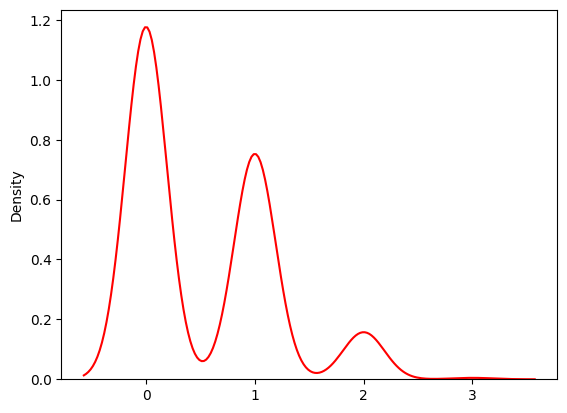

In [37]:
import seaborn as sns
sns.distplot(num_noise_feats, hist=False, kde=True, kde_kws={'label': 'test'}, color='red')